In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tqdm.notebook import tqdm

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 87% 105M/121M [00:00<00:00, 113MB/s] 
100% 121M/121M [00:00<00:00, 132MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
TRAIN_DIR = '/content/images/train'
TEST_DIR = '/content/images/validation'

In [6]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir,label, imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [7]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

disgust completed
neutral completed
surprise completed
fear completed
happy completed
sad completed
angry completed


In [8]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

disgust completed
neutral completed
surprise completed
fear completed
happy completed
sad completed
angry completed


In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode = "grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48,48,1)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [12]:
x_train = train_features/255.0
x_test = test_features/225.0

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [14]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(48, 48, 1)))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 22, 22, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 9, 9, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 1296)              0         
                                                                 
 dense (Dense)               (None, 120)               1

In [17]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [18]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [19]:
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks= early_stopping)

Epoch 1/50
901/901 [==============================] - 10s 7ms/step - loss: 1.6859 - accuracy: 0.3347 - val_loss: 1.6394 - val_accuracy: 0.3651
Epoch 2/50
901/901 [==============================] - 4s 5ms/step - loss: 1.6178 - accuracy: 0.3657 - val_loss: 1.6136 - val_accuracy: 0.3633
Epoch 3/50
901/901 [==============================] - 6s 6ms/step - loss: 1.5697 - accuracy: 0.3852 - val_loss: 1.5629 - val_accuracy: 0.3958
Epoch 4/50
901/901 [==============================] - 4s 5ms/step - loss: 1.5198 - accuracy: 0.4097 - val_loss: 1.5365 - val_accuracy: 0.4019
Epoch 5/50
901/901 [==============================] - 5s 5ms/step - loss: 1.4613 - accuracy: 0.4325 - val_loss: 1.5114 - val_accuracy: 0.4212
Epoch 6/50
901/901 [==============================] - 5s 6ms/step - loss: 1.3961 - accuracy: 0.4628 - val_loss: 1.4892 - val_accuracy: 0.4271
Epoch 7/50
901/901 [==============================] - 4s 5ms/step - loss: 1.3251 - accuracy: 0.4946 - val_loss: 1.4827 - val_accuracy: 0.4326
Epoch

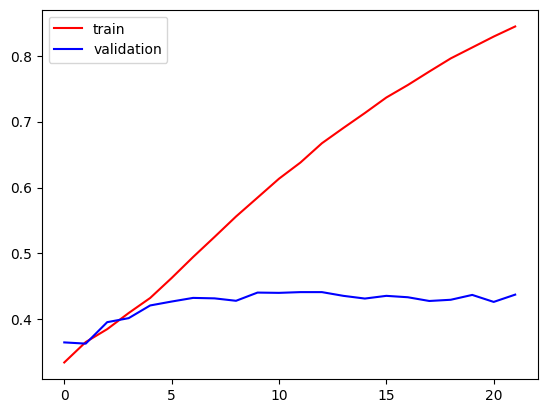

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'],color = 'blue', label = 'validation')
plt.legend()
plt.show()

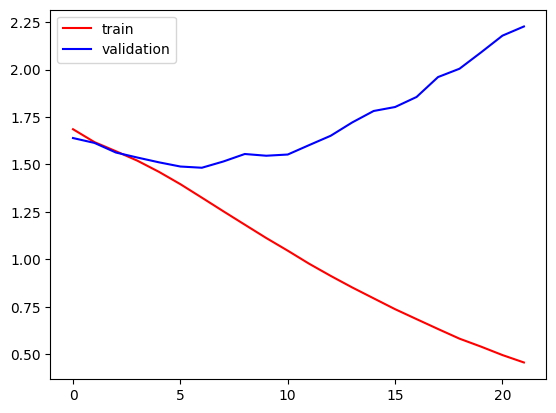

In [21]:
plt.plot(history.history['loss'],color = 'red', label = 'train')
plt.plot(history.history['val_loss'],color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [22]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
